# Sentiment Classification
## HW-4
### Daria Matyash


[Tutorial](https://huggingface.co/docs/transformers/tasks/sequence_classification) from HuggingFace

In [6]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 35.4 MB/s 
     |████████████████████████████████| 6.5 MB 18.0 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 
     |████████████████████████████████| 895 kB 20.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
import transformers
from transformers import AutoTokenizer, BertTokenizer,BertModel, Trainer, TrainingArguments
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

I decided to use `bert-base-multilingual-cased` after a few [experiments](https://colab.research.google.com/drive/1_5mI--LSHEGX_YVrtjksBF-ZS13lvy9l?usp=sharing) with `bert-base-multilingual-cased`and `prajjwal1/bert-tiny`.
It was emperically found, that higher results can be achived when we fine-tune large multilingual model.

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

# Data

## Download & Open

In [3]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 54.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 51.2MB/s]


Open data, look at its size

In [10]:
df = pd.read_csv("reviews.csv")
df.shape

(15746, 11)

In [11]:
df = df.head(7000)
df.shape

(7000, 11)

Watch at first two rows in dataset

In [12]:
df.head(2)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo


## Brief analysis

Our target is a "score" column. Take a look at the class distibution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


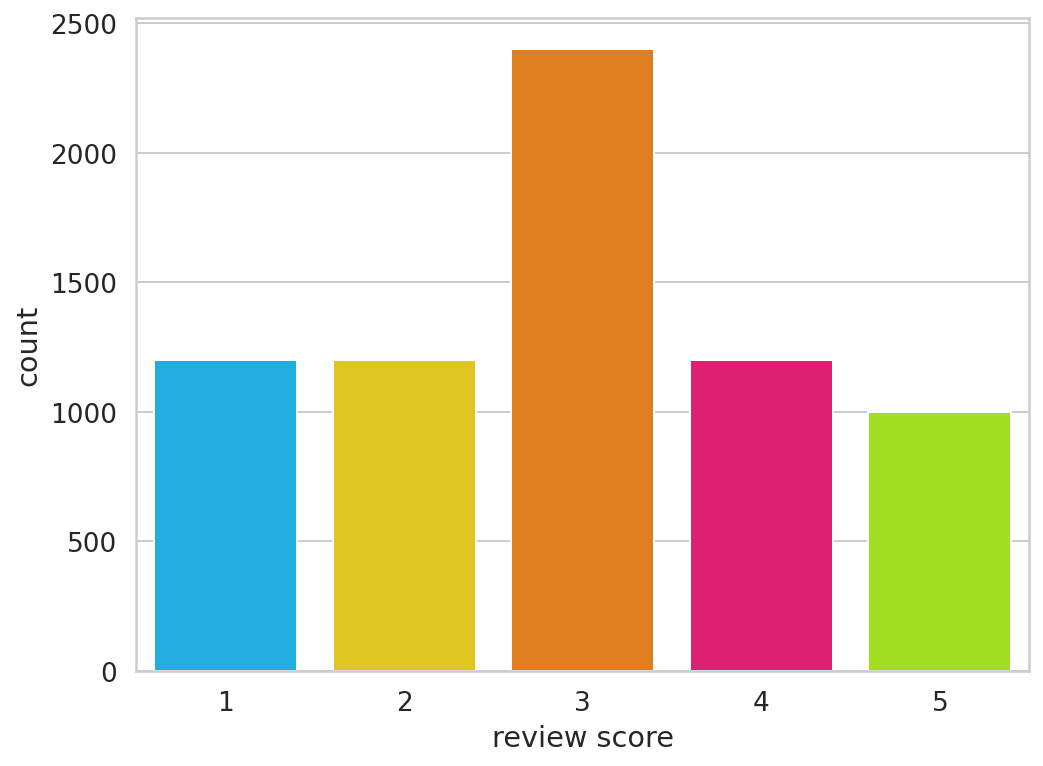

In [13]:
sns.countplot(df.score)
plt.xlabel('review score');

The "3" class is mostly presented in out dataset, there might be some problems connected with it:


*   a model might overfit on class "3" or mix any other classes with it quite often
*   class "3" is quite strange itself as it is something really BETWEEN "the bad" and "the good"


In order to solve the problem of unbalanced data we will modify the dataset and have only three classe - positive (scores 5 and 5), neutral (score 3) and negative (scores 1 and 2):

In [14]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

Take a look at a new data's class distibution:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


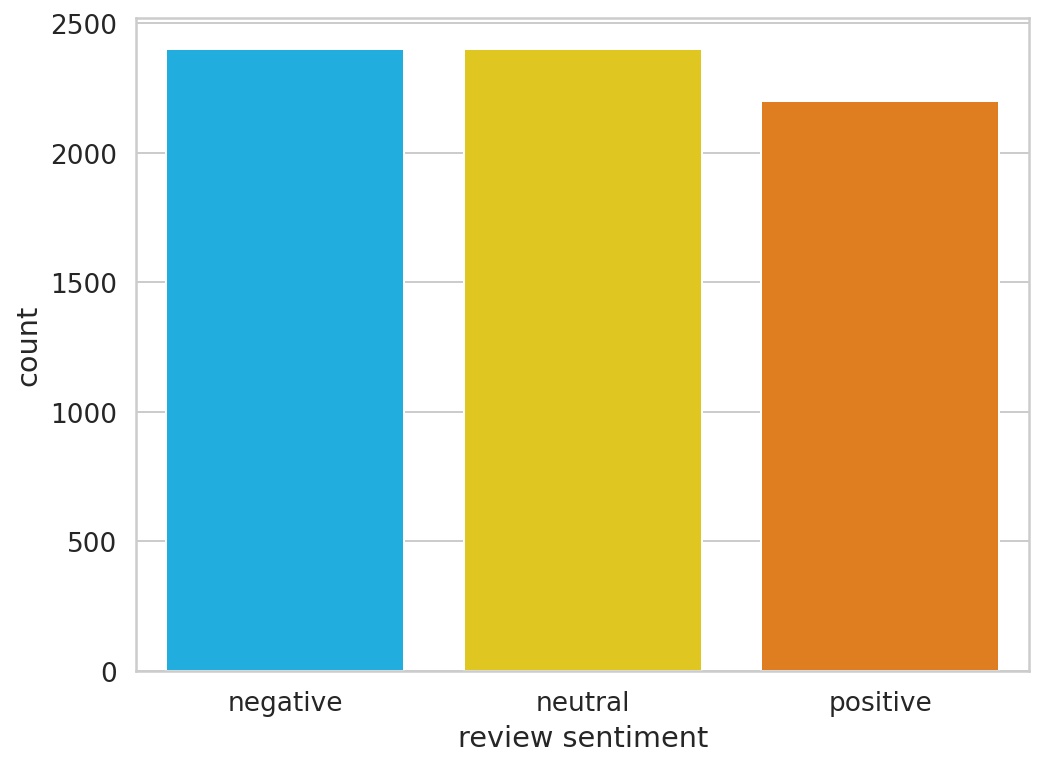

In [15]:
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

Great! In this case data looks more balanced!

## Preprocessing

In [16]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [17]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'st', '##uck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [12242, 10134, 146, 12469, 17555, 136, 146, 10392, 28780, 31746, 10160, 11816, 10142, 123, 20750, 119]


In [18]:
MAX_LEN = 160

In [19]:
encoding = tokenizer.encode_plus(
  'My mom wanted to help Suzy',
  max_length=MAX_LEN,
  add_special_tokens=True, # add '[CLS]' and '[SEP]' tokens
  return_token_type_ids=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # return tensor PyTorch
  truncation=True
)
encoding

{'input_ids': tensor([[  101, 11590, 46912, 10147, 22591, 10114, 15217, 12271, 12547,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

## Dataset Class, split to train-val-test, etc.

In [20]:
class SentimentDataset(torch.utils.data.Dataset):

  def __init__(self, reviews, labels, tokenizer, max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.long)
    }

In [21]:
def create_dataset(df, tokenizer, max_len):
  ds = SentimentDataset(
    reviews=df.content.to_numpy(),
    labels=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return ds

In [22]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
torch.cuda.is_available()

True

In [24]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [25]:
print(f'number of sentences in: \n df_train: {df_train.shape[0]}, \n df_val: {df_val.shape[0]}, \n df_test: {df_test.shape[0]}')

number of sentences in: 
 df_train: 5950, 
 df_val: 525, 
 df_test: 525


In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
BATCH_SIZE = 32
MAX_LEN = 160

train_dataset = create_dataset(df_train, tokenizer, MAX_LEN)
val_dataset = create_dataset(df_val, tokenizer, MAX_LEN)
test_dataset = create_dataset(df_test, tokenizer, MAX_LEN)

# Metrics: F1-score, precision, recall, accuracy

The following metrics will be used in order to evaluate models' performances. 

Used [resources](https://huggingface.co/docs/datasets/how_to_metrics) from HuggingFace as tutorial

In [28]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Model's performance presentation (2 points)

In this section we introduce three chosen texts from Google Play for future presentation of models' works.

We chose the sentences from three classes - positive, neutral and negative according to our own intuition: with which sentences' labelling I will agree myself? We did not want to choose the examples randomly as I do not agree with some markup in the dataset.

## Negative-neutral-positive examples for test (2 points)

In [29]:
ex_negative = """'The app crashes every now and then, no point of using the app when the timer freezes and the app stops responding. It is happening from the past 2 weeks. Kindly do something about it because a lot of people seem to be facing the same problem.'"""
ex_positive = """I love this app. It never crashes or loses my data. The collaborative features are great. This is the only task managment app I recommend."""
ex_neutral = """First impression is sufficient but not excellent. There are no settings for applying priorities to tasks and I couldn't find also a setting for repeating tasks (daily or for certain periods) for specified hours (from 17:00 - 20:00)."""

In [30]:
test_set = [ex_negative, ex_neutral, ex_positive]

## Testing functions

In [31]:
def test_func(model, text):
  tokenized = tokenizer(text, return_tensors='pt')
  logits = model(tokenized['input_ids'], tokenized['attention_mask'])[0]
  pred = torch.argmax(F.softmax(logits, dim=0))
  return pred.item()

def test_func2(test_set, model):
  true_labels = [0, 1, 2]
  pred_labels = []
  for text in test_set:
    pred_labels.append(test_func(model, text))
  return pd.DataFrame({'text': test_set, 'true': true_labels, 'predicted': pred_labels})

# Training Args (1 point)

[Documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.no_cuda) from HuggingFace

Here I explain all arguements for training

In [32]:
NUM_CLASSES = len(df_train['sentiment'].unique()) #number of classes to predict - 3 (0, 1, 2)
print('NUM_CLASSES: ', NUM_CLASSES)

NUM_CLASSES:  3


In [33]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

In [34]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
WEIGHT_DECAY = 1e-2
METRIC_NAME = 'f1'


1.   output_dir='./results/sentiment-classifier', # output directory
2.   num_train_epochs=NUM_EPOCHS,     # total number of training epochs
3. num_train_epochs=NUM_EPOCHS,     # total number of training epochs
4.    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
5.   per_device_eval_batch_size=BATCH_SIZE,   # batch size for evaluation
6.   warmup_steps=500,                # number of warmup steps for learning rate scheduler
7.    weight_decay=WEIGHT_DECAY,       # strength of weight decay -> changed to AdamW - optimizer for fine-tuning
8.    logging_dir='./logs',            # directory for storing logs
9.    logging_steps=100,               # log every 10 steps
10.    do_eval=True,                    # to run evaluation on the validation set
11.    do_train=True,                   # to run training
12.    evaluation_strategy = "epoch",   # save metrcis after every epoch
13.    save_strategy = "epoch",         # save metrcis after every epoch
14.    metric_for_best_model=METRIC_NAME, # for other model's comparison we use F1 especially
15.   fp16=True                       # use int16 for computational optimization
)

# Experiments

## Basic SentimentClassifier (2 points)

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes, loss_fn):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.loss_fn = loss_fn
  
  def forward(self, input_ids, attention_mask, labels=None):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    output = self.out(output)
    
    if labels is not None:
      loss = loss_fn(output, labels)
      return (loss, output)
    
    return output

In [ ]:
NUM_CLASSES = len(df_train['sentiment'].unique())
print('NUM_CLASSES: ', NUM_CLASSES)
loss_fn = nn.CrossEntropyLoss()
model = SentimentClassifier(n_classes=NUM_CLASSES, loss_fn=loss_fn)
model = model.to(device)

loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type

NUM_CLASSES:  3


loading weights file https://huggingface.co/bert-base-multilingual-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a m

In [ ]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

BATCH_SIZE = 32
NUM_EPOCHS = 3
WEIGHT_DECAY = 1e-2
METRIC_NAME = 'f1'

training_args = TrainingArguments(
    output_dir='./results/sentiment-classifier',          # output directory
    num_train_epochs=NUM_EPOCHS,     # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,       # strength of weight decay -> changed to AdamW - optimizer for fine-tuning
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # log every 10 steps
    do_eval=True,                    # to run evaluation on the validation set
    do_train=True,                   # to run training
    evaluation_strategy = "epoch",   # save metrcis after every epoch
    save_strategy = "epoch",         # save metrcis after every epoch
    metric_for_best_model=METRIC_NAME, # for other model's comparison we use F1 especially
    fp16=True                       # use int16 for computational optimization
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# from transformers import AdamW
# optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

Using amp half precision backend


### Report

In [ ]:
train_results = trainer.train()

***** Running training *****
  Num examples = 5950
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 558


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.069900,0.827068,0.617143,0.596981,0.603867,0.617143
2,0.757600,0.686811,0.714286,0.722322,0.753290,0.714286
3,0.631700,0.618661,0.744762,0.741104,0.740158,0.744762


***** Running Evaluation *****
  Num examples = 525
  Batch size = 32
Saving model checkpoint to ./results/sentiment-classifier/checkpoint-186
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 525
  Batch size = 32
Saving model checkpoint to ./results/sentiment-classifier/checkpoint-372
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 525
  Batch size = 32
Saving model checkpoint to ./results/sentiment-classifier/checkpoint-558
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




In [ ]:
pd.DataFrame([train_results.metrics]).T

,0
train_runtime,237.184700
train_samples_per_second,75.258000
train_steps_per_second,2.353000
total_flos,0.000000
train_loss,0.783973
epoch,3.000000


### Test

In [ ]:
test_results = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
test_results

***** Running Evaluation *****
  Num examples = 525
  Batch size = 32


{'epoch': 3.0,
 'test_accuracy': 0.7276190476190476,
 'test_f1': 0.7265829725829726,
 'test_loss': 0.6924113035202026,
 'test_precision': 0.7267264616284224,
 'test_recall': 0.7276190476190476,
 'test_runtime': 2.1627,
 'test_samples_per_second': 242.751,
 'test_steps_per_second': 7.861}

In [ ]:
model_1 = trainer.model.to('cpu')

In [ ]:
test_func2(test_set, model_1)

,text,true,predicted
0,"'The app crashes every now and then, no point ...",0,0
1,First impression is sufficient but not excelle...,1,1
2,I love this app. It never crashes or loses my ...,2,2


All the examples are detected correctly, on test dataset model's predictions are made with 72% acccuracy and almost 0.73 F1-score and only after 3 epochs of traing!

## Sentiment Classifier + CLS

In [ ]:
class SentimentClassifierCLS(nn.Module):

  def __init__(self, n_classes):

    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
    self.out = nn.Linear(self.bert.config.hidden_size + 128, n_classes)
    self.n_classes = n_classes
  
  def forward(self,        
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None
    ):

    last_hidden_state, pooled_output = self.bert(
                                  input_ids=input_ids,
                                  attention_mask=attention_mask,
                                  return_dict=False)
    
    cls = last_hidden_state[:,0,:] # CLS token
    pooled_output = self.linear(self.drop(pooled_output)) 
    stacked_layers = torch.hstack([cls, pooled_output]) # CLS + output
    
    logits = self.out(stacked_layers)

    loss = None
    if labels is not None:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1))
    output = (logits,)
    return ((loss,) + output) if loss is not None else output

In [35]:
class SentimentClassifierCLS(nn.Module):

  def __init__(self, n_classes, loss_fn):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.loss_fn = loss_fn
  
  def forward(self, input_ids, attention_mask, labels=None):
    last_hidden_state, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)

    output = self.drop(pooled_output)
    cls = self.drop(last_hidden_state[:,0,:])

    output = torch.stack([output, cls]).mean(dim=0)
    output = self.out(output)

    if labels is not None:
      loss = loss_fn(output, labels)
      return (loss, output)
    
    return output

In [36]:
NUM_CLASSES = len(df_train['sentiment'].unique())
print('NUM_CLASSES: ', NUM_CLASSES)
loss_fn = nn.CrossEntropyLoss()
modelCLS = SentimentClassifierCLS(n_classes=NUM_CLASSES, loss_fn=loss_fn)
modelCLS = modelCLS.to(device)

NUM_CLASSES:  3


Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
training_args = TrainingArguments(
    output_dir='./results/sentiment-classifier-CLS',          # output directory
    num_train_epochs=NUM_EPOCHS,     # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,       # strength of weight decay -> changed to AdamW - optimizer for fine-tuning
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # log every 10 steps
    do_eval=True,                    # to run evaluation on the validation set
    do_train=True,
    evaluation_strategy = "epoch",   # save metrcis after every epoch
    save_strategy = "epoch",         # save metrcis after every epoch
    metric_for_best_model=METRIC_NAME,
    fp16=True
)

In [38]:
trainerCLS = Trainer(
    model=modelCLS,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

Using amp half precision backend


### Report

In [ ]:
train_results = trainerCLS.train()

***** Running training *****
  Num examples = 5950
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 558


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.068100,0.786446,0.638095,0.634986,0.639830,0.638095
2,0.751800,0.672526,0.708571,0.713395,0.731216,0.708571
3,0.617400,0.606957,0.742857,0.745410,0.752894,0.742857


***** Running Evaluation *****
  Num examples = 525
  Batch size = 32
Saving model checkpoint to ./results/sentiment-classifier-CLS/checkpoint-186
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 525
  Batch size = 32
Saving model checkpoint to ./results/sentiment-classifier-CLS/checkpoint-372
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 525
  Batch size = 32
Saving model checkpoint to ./results/sentiment-classifier-CLS/checkpoint-558
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




In [38]:
pd.DataFrame([train_results.metrics]).T

,0
train_runtime,2.103259e+03
train_samples_per_second,8.487000e+00
train_steps_per_second,2.650000e-01
total_flos,1.467680e+15
train_loss,1.015883e+00
epoch,3.000000e+00


### Test

In [41]:
test_results = trainerCLS.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
test_results

***** Running Evaluation *****
  Num examples = 525
  Batch size = 32


{'epoch': 3.0,
 'test_accuracy': 0.7428571428571429,
 'test_f1': 0.741296934644303,
 'test_loss': 0.6548467874526978,
 'test_precision': 0.7407551183073479,
 'test_recall': 0.7428571428571429,
 'test_runtime': 20.1749,
 'test_samples_per_second': 26.022,
 'test_steps_per_second': 0.843}

In [42]:
model_2 = trainerCLS.model.to('cpu')
test_func2(test_set, model_2)

,text,true,predicted
0,"'The app crashes every now and then, no point ...",0,0
1,First impression is sufficient but not excelle...,1,1
2,I love this app. It never crashes or loses my ...,2,2


All the test sentences were predicted correctly and there is anincrease in accuracy and F1-score!

## BertForSequenceClassification

I chose bert-small as it is quite lightweighted and fast

In [31]:
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
modelBSC = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [32]:
from transformers import BertForSequenceClassification
from transformers import BertConfig

modelBSC = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
modelBSC.to(device) 

#change number of classes to 3
config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
config.num_labels = len(class_names)

modelBSC = BertForSequenceClassification(config)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [33]:
training_args = TrainingArguments(
    output_dir='./results/bert-for-sequence-classification',          # output directory
    num_train_epochs=NUM_EPOCHS,     # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,       # strength of weight decay -> changed to AdamW - optimizer for fine-tuning
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # log every 10 steps
    do_eval=True,                    # to run evaluation on the validation set
    do_train=True,
    evaluation_strategy = "epoch",   # save metrcis after every epoch
    save_strategy = "epoch",         # save metrcis after every epoch
    metric_for_best_model=METRIC_NAME,
    fp16=True
)

In [34]:
device

device(type='cuda', index=0)

In [35]:
trainerBSC = Trainer(
    model=modelBSC,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)


Using amp half precision backend


### Report

In [36]:
train_results = trainerBSC.train()

***** Running training *****
  Num examples = 5950
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 558


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.107100,1.069610,0.436190,0.404462,0.505093,0.436190
2,1.040500,0.898109,0.579048,0.587122,0.613948,0.579048
3,0.941100,0.800440,0.619048,0.615919,0.626496,0.619048


***** Running Evaluation *****
  Num examples = 525
  Batch size = 32
Saving model checkpoint to ./results/bert-for-sequence-classification/checkpoint-186
Configuration saved in ./results/bert-for-sequence-classification/checkpoint-186/config.json
Model weights saved in ./results/bert-for-sequence-classification/checkpoint-186/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 525
  Batch size = 32
Saving model checkpoint to ./results/bert-for-sequence-classification/checkpoint-372
Configuration saved in ./results/bert-for-sequence-classification/checkpoint-372/config.json
Model weights saved in ./results/bert-for-sequence-classification/checkpoint-372/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 525
  Batch size = 32
Saving model checkpoint to ./results/bert-for-sequence-classification/checkpoint-558
Configuration saved in ./results/bert-for-sequence-classification/checkpoint-558/config.json
Model weights saved in ./results/bert-for-sequence-classif

In [41]:
pd.DataFrame([train_results.metrics]).T

,0
train_runtime,2.103259e+03
train_samples_per_second,8.487000e+00
train_steps_per_second,2.650000e-01
total_flos,1.467680e+15
train_loss,1.015883e+00
epoch,3.000000e+00


### Test

In [44]:
test_results = trainerBSC.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
test_results

***** Running Evaluation *****
  Num examples = 525
  Batch size = 32


{'epoch': 3.0,
 'test_accuracy': 0.5885714285714285,
 'test_f1': 0.5820570113133925,
 'test_loss': 0.8677805066108704,
 'test_precision': 0.5951901171007155,
 'test_recall': 0.5885714285714285,
 'test_runtime': 20.1032,
 'test_samples_per_second': 26.115,
 'test_steps_per_second': 0.846}

In [45]:
model_3 = trainerBSC.model.to('cpu')
test_func2(test_set, model_3)

,text,true,predicted
0,"'The app crashes every now and then, no point ...",0,0
1,First impression is sufficient but not excelle...,1,0
2,I love this app. It never crashes or loses my ...,2,0


We can see a quite confusing situation: all of the test sentences were detected as negative class. We might suppose that the model has overfitted somehow, but it is not right as we can see, though quite low, results of model's performance on test dataset. As all classes are balanced, accuracy of 59% and F1-score of 0.58 can give us a hope that, with more epochs on training, the results can be higher and the model might not be biased as the loss during training was also lowering (thogh, not so fast as it was in other models' situations)

##  SentimentClassifier + CLS tokens from all layers

In [34]:
class SentimentClassifierPooledCLS(nn.Module):

  def __init__(self, n_classes, loss_fn):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, output_hidden_states=True)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.loss_fn = loss_fn
  
  def forward(self, input_ids, attention_mask, labels=None):

    last_hidden_state, pooled_output, hidden_states = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    
    cls = [state[:,0,:] for state in hidden_states]
    output = torch.stack(cls).mean(dim=0)
    output = self.out(output)

    if labels is not None:
      loss = loss_fn(output, labels)
      return (loss, output)
    
    return output

In [35]:
NUM_CLASSES = len(df_train['sentiment'].unique())
print('NUM_CLASSES: ', NUM_CLASSES)
loss_fn = nn.CrossEntropyLoss()
modelPCLS = SentimentClassifierPooledCLS(n_classes=NUM_CLASSES, loss_fn=loss_fn)
modelPCLS = modelPCLS.to(device)

NUM_CLASSES:  3


Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
training_args = TrainingArguments(
    output_dir='./results/sentiment-classifier-PooledCLS',          # output directory
    num_train_epochs=NUM_EPOCHS,     # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,       # strength of weight decay -> changed to AdamW - optimizer for fine-tuning
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # log every 10 steps
    do_eval=True,                    # to run evaluation on the validation set
    do_train=True,                   # to run training
    evaluation_strategy = "epoch",   # save metrcis after every epoch
    save_strategy = "epoch",         # save metrcis after every epoch
    metric_for_best_model=METRIC_NAME, # for other model's comparison we use F1 especially
    fp16=True                       # use int16 for computational optimization
)

In [37]:
trainerPCLS = Trainer(
    model=modelPCLS,                     # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

Using amp half precision backend


### Report

In [38]:
train_results = trainerPCLS.train()

***** Running training *****
  Num examples = 5950
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 558


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.050500,0.752669,0.662857,0.656399,0.653744,0.662857
2,0.737900,0.672850,0.714286,0.721796,0.772462,0.714286
3,0.600800,0.565709,0.761905,0.761608,0.762124,0.761905


***** Running Evaluation *****
  Num examples = 525
  Batch size = 32
Saving model checkpoint to ./results/sentiment-classifier-PooledCLS/checkpoint-186
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 525
  Batch size = 32
Saving model checkpoint to ./results/sentiment-classifier-PooledCLS/checkpoint-372
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 525
  Batch size = 32
Saving model checkpoint to ./results/sentiment-classifier-PooledCLS/checkpoint-558
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




In [39]:
pd.DataFrame([train_results.metrics]).T

,0
train_runtime,2115.691000
train_samples_per_second,8.437000
train_steps_per_second,0.264000
total_flos,0.000000
train_loss,0.762267
epoch,3.000000


### Test

In [40]:
test_results = trainerPCLS.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
test_results

***** Running Evaluation *****
  Num examples = 525
  Batch size = 32


{'epoch': 3.0,
 'test_accuracy': 0.7447619047619047,
 'test_f1': 0.7439634471399421,
 'test_loss': 0.6443058848381042,
 'test_precision': 0.7437783665197916,
 'test_recall': 0.7447619047619047,
 'test_runtime': 20.0384,
 'test_samples_per_second': 26.2,
 'test_steps_per_second': 0.848}

In [42]:
model_4 = trainerPCLS.model.to('cpu')
test_func2(test_set, model_4)

,text,true,predicted
0,"'The app crashes every now and then, no point ...",0,0
1,First impression is sufficient but not excelle...,1,1
2,I love this app. It never crashes or loses my ...,2,2


All the examples are predicted correctly by the model! The test accuracy is almost 75% and F1-score is 0.75 which is the best result now!!!

# Conclusions

We conducted experiments with the following models:


1.   Basic Bert Senttiment Classifier
2.   Sentiment Classifier + CLS tokens from the last layer
3. BertForSequenceClassification
4. Sentiment Classifier + CLS tokens from all layers

You can see the table of results below:

| Model      | F1 | Accuracy |
| :---        |    :----:   |        ---: |
| Basic Bert Senttiment Classifier      | 0.7266       | 0.7276   |
| Sentiment Classifier + CLS tokens from the last layer   | 0.7413       | 0.7429 |
|BertForSequenceClassification|0.5802|0.5886|
|**Sentiment Classifier + CLS tokens from all layers**|**0.744**|**0.7447**|


All the models were trained on 3 epochs, but, of course, with the increase of number of epochs the scores can also be higher.
The best model is Sentiment Classifier with CLS tokens from all layers, but there is a tiny difference between this model and Sentiment Classifier with CLS tokens only from the last layer. The third place is occupied by basic Bert Sentiment Classifier with a 0.22 difference in accuracy, which is still can be considered as successfull result! The pretrained model did not perform as well as the mentioned ones, but some layers' freezing might have imporoved the results.

All of the models predicted all test sentences correctly, exept BertForSequenceClassification which made 1 out 3 correct answers.